EOSC 511: Lab 5b

Add foxes that prey on rabbits to Daisy World. By changing the various degrees of freedom in this problem, look for “predator-prey” oscillations, in which the fox and rabbit populations go through periodic highs and lows. Hand-in a discussion and plots describing and showing the most interesting oscillations/longest non-trivial steady state you can find. Discuss the following:

 - what this simulation can teach us about the real World.
 - the limitations of your model
 - some discussion of whether the various parameter values you use are reasonable, given what you know about daisies and mammals (e.g. what do your birth and death rates tell you about the average lifespan of a fox vs a rabbit vs a daisy on your planet, or the number of rabbits being born per rabbit?).
 - describe (but don't code, and equations aren't necessary), an additional layer of complexity that could be added to the model to make it more realistic

1. Add the foxes to DaisyWorld:

The rate of change of the fox population will like:
$$
\frac{dA_f}{dt} = A_f ( BR_f - \chi_f)
$$
where $\chi_f$ is the fox death rate, $x_f$ is the fraction of space available to the foxes, and $BR_f$ is the fox birth rate,
$$
BR_f = C_{BR_f} x_f A_r.
$$
The foxes will effect the rabbit population so their population equation becomes,
$$
\frac{dA_r}{dt} = A_r ( BR_r - \chi_r) - GR_f
$$
where,
$$
GR_f = C_{GR_f} A_f A_r
$$
and,
$$
BR_r = C_{BR_r}(x_r(A_w + A_b)).
$$
(I've fixed where I was multiplying by x_r twice in lab 5a.)

The rate of change of the white daisies population is still,
$$
\frac{dA_w}{dt} = A_w ( \beta_w x - \chi) - GR_w
$$

and the rate of change of the black daisies is,
$$
\frac{dA_b}{dt} = A_b ( \beta_b x - \chi) - GR_b
$$

where 
$$
GR_w = C_{GR_r} A_r A_w
$$
$$
GR_b = C_{GR_r} A_r A_b
$$

$A_f$ = fox population \
$A_r$ = rabbit population \
$A_w, A_b$ = daisie populations \
$BR_f$ = fox birth rate \
$BR_r$ = rabbit birth rate \
$C_{BR_f}, C_{BR_r}$ = fox and rabbit birth rate coefficient \
$GR_f$ = fox grazing rate \
$GR_w, GR_b$ = grazing rate of rabbits on the white and black daisies \
$C_{GR_f}, C_{GR_r}$ = fox and rabbit grazing rate coefficient \
$x,x_r,x_f$ = fractional space available for each species \
$\chi, \chi_r, \chi_f$ = the death rate of each species 


In [13]:
# functions for problem initial
import context;
from numlabs.lab5.lab5_funs import Integrator;
import numpy as np;
from collections import namedtuple;


class RabInteg54(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rab_i fox_i'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.rab_i, self.initvars.fox_i])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=initial rabbits
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        
        #beta is the daisie growth rate
        #chi is the daisie death rate
        #bare is the fractional coverage of the daisies

        # rab_i = y[2]
        # rabbits can exist on top of daisies
        barerab = 1.0 - y[2]
        barefox = 1.0 - y[3]

        # fox and rabbit birth rate
        rab_br = user.Crbr * (barerab * (y[0] + y[1]))
        fox_br = user.Cfbr * (barefox * y[2])
        
        # fox and rabbit grazing rate 
        wd_graze = user.Crgr * y[2] * y[0]
        bd_graze = user.Crgr * y[2] * y[1]
        r_graze = user.Cfgr * y[3] * y[2]

        # create a 1 x 2 element vector to hold the derivitive
        # the grazing rate is subtracted from the
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi) - wd_graze
        f[1] = y[1] * (beta_b * bare - user.chi) - bd_graze
    
        # add the rabbit population to f
        f[2] = y[2] * (rab_br - user.rabchi) - r_graze

        # fox population
        f[3] = y[3] * (fox_br - user.foxchi)
        return f

Black daisie steady state value =  1.3352205220997962e-09


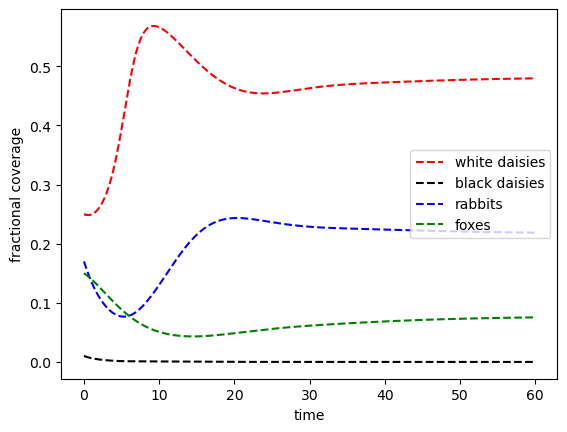

In [14]:
# Solve and plot for problem initial
import matplotlib.pyplot as plt
import pandas as pd

theSolver = RabInteg54('initial-grace1.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
species = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, species['white'])
line2, = theAx.plot(timevals, species['black'])
line3, = theAx.plot(timevals, species['rabbits'])
line4, = theAx.plot(timevals, species['foxes'])
line1.set(linestyle='--', color='r', label='white daisies')
line2.set(linestyle='--', color='k', label='black daisies')
line3.set(linestyle='--', color='b', label='rabbits')
line4.set(linestyle='--', color='g', label='foxes')
#theAx.set_title('C_rbr = 1, C_rgr = 1, chi_rabbits = 0.3')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
print('Black daisie steady state value = ', yvals[-1,1])

2. Discussion:

 - what this simulation can teach us about the real World.
   
This lab illustrates how in the hierarchy of species, there must be a greater abundance of food resources at the lowest level. There must be more daisies then there are rabbits who eat them, and there must be more rabbits than foxes who eat them. The fox population is more sensitive than that of the daisies and rabbits. Changes in the initial parameters of both the rabbits and daisies effect the foxes even though the fox don't directly interact with the daisies. There is a chain reaction when the original food resource is changed. 


 - the limitations of your model

There is a smaller range of the initial population I can use for the foxes. As I already mentioned, the initial popluation of each species has to be decreasing as we move up the food chain, and the death rate of the foxes has to be smaller then that of the rabbits and daisies to find a non-zero eq., where as when it was just the rabbits and daisies, I could move the rabbit death rate up and down a bit and still find a non-zero equilibrium. But now with the foxes, there seems to be a broader range of values I can use for the birth and grazing rates.

 - some discussion of whether the various parameter values you use are reasonable, given what you know about daisies and mammals (e.g. what do your birth and death rates tell you about the average lifespan of a fox vs a rabbit vs a daisy on your planet, or the number of rabbits being born per rabbit?). 

I found that a non zero equilibirum can be found for all species when the foxes have a life that is about 2 thirds of the rabbits and foxes, but an actual foxes lifespan is more like one third of a rabbits. We also are able to make the lifespan of the daisies the same as the rabbits, which doesn't make sense since daisies typically have lifespans on the order of days. In the figure above, the rabbit birth rate is set to each rabbit birthing 1 rabbit, but rabbits usually give birth to 5-12 babies. But if we raise the birth rate to 5 babies per rabbit, the equilibrium goes to zero. We can lower the grazing rate of each rabbit to find the non-zero equilibrium again but then each rabbit only eating a portion of a daisie doesn't make sense either. So, we usually have to sacrifice the accuracy of one parameter in order to make another one more realistic.  

 - describe (but don't code, and equations aren't necessary), an additional layer of complexity that could be added to the model to make it more realistic

The daisy have a growth rate that is dependant on the temperature which depends on the solar flux in DaisyWorld. The coding of our equations sujest that the amount of solar radiation that hits the ground is the same everywhere in DaisyWorld. But we know that the sun hits the earth at different angles at different latitudes which changes the intensity of the solar flux. So, temperature changes with changes in latitude would make DaisyWorld more realistic. And we could also add seasonal cyles to DaisyWorld as they are also dependant on the planets position to the sun.

-----------------------------------------------------------------------------------------------------------------------------------------

inital-grace.yaml

timevars:\
$\>$  dt: 0.05\
$\>$  tstart: 0.0\
$\>$  tend: 50.0\
uservars:\
$\>$  albedo_white: 0.75\
$\>$  chi: 0.3\
$\>$  rabchi: 0.3\
$\>$  foxchi: 0.2\
$\>$  Crgr: 1\
$\>$  Crbr: 1\
$\>$  Cfgr: 1\
$\>$  Cfbr: 1\
$\>$  S0: 3668.0\
$\>$  L: 1.3\
$\>$  albedo_black: 0.25\
$\>$  R: 0.12\
$\>$  albedo_ground: 0.5\
initvars:\
$\>$  whiteconc: 0.24\
$\>$  blackconc: 0.01\
$\>$  rab_i: 0.17\
$\>$  fox_i: 0.15\
adaptvars:\
$\>$  dtpassmin: 0.1\
$\>$  dtpassmax: 5.0\
$\>$  dtfailmax: 0.5\
$\>$  dtfailmin: 0.1\
$\>$  s: 0.9\
$\>$  rtol: 1.0e-05\
$\>$  atol: 1.0e-05\
$\>$  maxsteps: 2000.0\
$\>$  maxfail: 60.0